# Laboratorio de Habla 3: Construcción de un Vocoder

## Objetivos de Aprendizaje
1. Manipular y visualizar señales de voz en Julia.
2. Realizar un análisis LPC de la señal de voz en Julia.
3. Reconstruir señales usando filtros de reconstrucción.

## Consejos para la Solución
- Utiliza las convenciones de Julia para escribir código.
- Copia el texto de los enunciados como parte (comentada) de un fichero de Julia para ejecutarlo.

## Introducción: la Vocodificación LPC
...

## Ejercicio 1: Análisis Exploratorio de la Señal
### Objetivo
Determinar si la señal puede ser sujeta a codificación LPC efectiva.
### Contenido


1. Lea y reproduzca la señal de voz proporcionada.


2. Represente el sonido en el dominio del tiempo.


3. Represente la energía localizada y la tasa de cruces por cero como función del tiempo, entramando la señal con diferentes tamaños de ventana y usando las primitivas desarrolladas en la práctica 2.



## Ejercicio 2: Análisis de una trama
### Objetivo
Desarrollar el código de análisis-síntesis.
### Contenido


In [92]:
Pkg.add("StatsBase")

   Resolving package versions...


    Updating `~/.julia/environments/v1.9/Project.toml`
  [2913bbd2] + StatsBase v0.34.2
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [104]:
# imports
using DSP
using FFTW
using WAV
using Plots
using ToeplitzMatrices
using StatsBase
using LinearAlgebra

plotlyjs()

Plots.PlotlyJSBackend()


1. Seleccione y visualice en el tiempo y la frecuencia una trama sonora de la señal.


In [ ]:
confront, fs = wavread("./confront.wav")

d = (length(confront)-1)*(1/fs)
t = 0:1/fs:d

p1 = plot(t, confront, title="Signal (time)")

# calculate signal frecuency
contfront_fft = fftshift(fft(confront))
contfront_fft_module = abs.(contfront_fft)
frequencies = fftshift(fftfreq(length(t), fs))

p2 = plot(frequencies, contfront_fft_module, title="Signal (Frec)", xlabel="Frecuencies (Hz)", ylabel="|FFT|")

plot(p1, p2, layout=(2,1))


Visualmente, vemos una trama sonora por ejemplo desde el segundo 0.5 hasta el 0.7 aproximadamente, vamos a comprobarlo entramando la señal.

In [ ]:
# 
trama = confront[5800:6200]

d = (length(trama)-1)*(1/fs)
t = 0:1/fs:d

p1 = plot(t, trama, title="Signal (time)")

# calculate signal frecuency
trama_fft = fftshift(fft(trama))
trama_fft_module = abs.(trama_fft)
frequencies = fftshift(fftfreq(length(t), fs))

p2 = plot(frequencies, trama_fft_module, title="Signal (Frec)", xlabel="Frecuencies (Hz)", ylabel="|FFT|")

plot(p1, p2, layout=(2,1))

2. Obtenga la función de autocorrelación de la trama usando una función xcorr que reciba una trama y un orden y obtenga el vector de autocorrelación de ese orden.


In [ ]:
function autocorrelacion_trama(trama, orden)

  autocorrelacion = xcorr(trama, trama)

  orden = min(orden, length(autocorrelacion) - 1)

  autocorrelacion_orden_especifico = autocorrelacion[length(trama) + 1 : length(trama) + orden + 1]

  return autocorrelacion, autocorrelacion_orden_especifico
end

trama = confront[5800:6200]     # trama sonora

order = 100
autocorrelacion, acorr_order = autocorrelacion_trama(trama, order)

p1 = plot(autocorrelacion, title="Autocorrelation")
p2 = plot(acorr_order, title="Autocorrelation order $order")

plot(p1, p2, layout=(2,1))

3. Genere la matriz R usando la biblioteca ToeplitzMatrices.jl


In [86]:
function generar_matriz_R(trama, orden)
  # Calcula la autocorrelación de la trama hasta el orden deseado
  autocorrelacion, autocorrelacion_orden = autocorrelacion_trama(trama, orden)
  
  # Genera la matriz toeplitz a partir del vector de autocorrelación
  matriz_R = Toeplitz([autocorrelacion_orden[1]; autocorrelacion_orden[2:end]], 
                        [autocorrelacion_orden[1]; reverse(autocorrelacion_orden[2:end])])
  return matriz_R
end

trama = confront[5800:6200]
orden_autocorrelacion = 5

matriz_R = generar_matriz_R(trama, orden_autocorrelacion)

# show matrix
show(IOContext(stdout, :limit=>false), MIME"text/plain"(), matriz_R)

6×6 Toeplitz{Float64, Vector{Float64}, Vector{Float64}}:
 4.6555   1.71923  2.46804  3.19094  3.83453  4.32549
 4.32549  4.6555   1.71923  2.46804  3.19094  3.83453
 3.83453  4.32549  4.6555   1.71923  2.46804  3.19094
 3.19094  3.83453  4.32549  4.6555   1.71923  2.46804
 2.46804  3.19094  3.83453  4.32549  4.6555   1.71923
 1.71923  2.46804  3.19094  3.83453  4.32549  4.6555

In [130]:
# test own toeplitz
function toeplitz(b,n)
  m = length(b)
  T = zeros(n+m-1,n)
  for i=1:m
    T[i : n+m : end] .= b[i]
  end
  return T
end

function coef(sw, orden)
  r, r_order = autocorrelacion_trama(sw, orden)[length(sw):end]
  R = toeplitz(r_order, orden)
  a = R \ r_order
  return a
end

trama = confront[5800:6200]
orden_autocorrelacion = 5
# autocorrelacion, autocorrelacion_orden = autocorrelacion_trama(trama, orden_autocorrelacion)

# R_matrix = toeplitz(autocorrelacion_orden, orden_autocorrelacion)
# show(IOContext(stdout, :limit=>false), MIME"text/plain"(), R_matrix)
ak = coef(trama, orden_autocorrelacion)
print(ak)


BoundsError: BoundsError: attempt to access Tuple{} at index [1]

4. Obtenga los coeficientes de predicción lineal usando el sistema anterior.


In [107]:
function tractoVocal(sw, p)
  c = xcorr(sw, sw)
  lags = 0:length(c)-1
  
  idx = findall(x -> x == 1, lags)[1]:findall(x -> x == p, lags)[end] 
  idx2 = findall(x -> x == 0, lags)[1]:findall(x -> x == p, lags)[end]
  r = c[idx]
  
  R = generar_matriz_R(sw, p)
  
  R_inv = inv(R)
  ak = R_inv * r
  
  return ak
end

trama = confront[5800:6200]
orden_autocorrelacion = 5

ak = tractoVocal(trama, orden_autocorrelacion)

MethodError: MethodError: no method matching ldiv!(::ToeplitzMatrices.ToeplitzFactorization{Float64, Toeplitz{Float64, Vector{Float64}, Vector{Float64}}, ComplexF64, FFTW.cFFTWPlan{ComplexF64, -1, true, 1, Tuple{Int64}}}, ::Matrix{Float64})

Closest candidates are:
  ldiv!(!Matched::Cholesky{T, <:StridedMatrix{T} where T}, ::StridedVecOrMat{T}) where T<:Union{Float32, Float64, ComplexF64, ComplexF32}
   @ LinearAlgebra /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/LinearAlgebra/src/cholesky.jl:576
  ldiv!(!Matched::Cholesky, ::AbstractVecOrMat)
   @ LinearAlgebra /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/LinearAlgebra/src/cholesky.jl:579
  ldiv!(!Matched::Bidiagonal, ::AbstractVecOrMat)
   @ LinearAlgebra /Applications/Julia-1.9.app/Contents/Resources/julia/share/julia/stdlib/v1.9/LinearAlgebra/src/bidiag.jl:729
  ...



## Ejercicio 3: Síntesis de una trama
### Objetivo
Depurar el código de análisis-síntesis.
### Contenido



1. Obtenga, para la trama dada, el error de predicción como una señal, filtrando la trama a través del filtro FIR inverso.


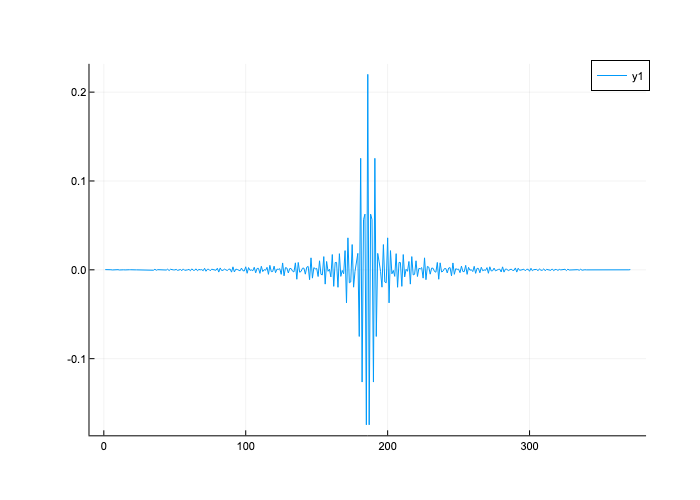

In [131]:
fil = remez(371, [0, 34, 35, 45, 46, 50], [0, 1, 0], Hz=100, maxiter=100)

plot(fil)

In [136]:

function coeficientes_prediccion_lineal(sw, orden)
  r = crosscov(sw, sw)
  R = Toeplitz(r[1:orden],  r[1:orden])
  a = R \ r[2:orden+1]
  return a
end

function error_prediccion(sw, orden)
  # Obtén los coeficientes de predicción lineal
  a = coeficientes_prediccion_lineal(sw, orden)
  
  # Filtro FIR inverso
  b = [1.0, -a']  # Los coeficientes son [1, -a[1], -a[2], ..., -a[p]]
  
  # Filtra la trama original
  print("this is b")
  println(b)
  error = DSP.conv(b[2], sw)
  
  return error
end

sw = confront[5800:6200]
orden = 2

error = error_prediccion(sw, orden)

this is bAny[1.0, [-1.2165974473116385 -0.2823240430937145]]


401×2 Matrix{Float64}:
 -0.00477097  -0.00110715
 -0.00477097  -0.00110715
  0.00477097   0.00110715
  0.00477097   0.00110715
  0.0143129    0.00332146
  0.0238549    0.00553577
  0.0143129    0.00332146
  0.0143129    0.00332146
  0.0238549    0.00553577
  0.0143129    0.00332146
  ⋮           
 -0.119274    -0.0276788
 -0.176526    -0.0409647
 -0.224236    -0.0520362
 -0.214694    -0.0498219
 -0.224236    -0.0520362
 -0.243319    -0.0564648
 -0.186068    -0.043179
 -0.1479      -0.0343217
 -0.119274    -0.0276788

2. Sintetice la trama de voz analizada mediante el filtro de síntesis calculado en el apartado 1.4


3. Inspeccione, auditivamente, en el tiempo y en la frecuencia las tramas de voz original y sintetizada. ¿Son correctos los coeficientes de análisis-síntesis?

## Ejercicio 4: Síntesis LPC
### Objetivo
Realizar el análisis-síntesis LPC de una elocución de voz.
### Contenido

1. Identificar si cada trama de voz es sonora o sorda usando tanto la tasa de cruces por cero como la energía localizada.
2. Calcular la frecuencia fundamental de las tramas sonoras, si puede, usando la FFT.
3. De nuevo, calcule la frecuencia fundamental pero usando en este caso la autocorrelación. ¿En qué propiedad fundamental de la teoría de señales se basa este método? Para responder, reflexione acerca de lo que es la función de autocorrelación desarrollada más arriba.
4. Encuentre una trama sorda y una trama sonora de su señal de voz como en 1.3 y calcule y visualice sus autocorrelaciones como en 2.2. Para la trama sonora, estime el tono fundamental como en 4.1
5. Halle los espectros de las tramas seleccionadas y represéntelos para explorarlos.
6. Construya una función que reciba una trama y devuelva todos los parámetros de análisis necesarios para re-sintetizar la trama.
7. Construya una función que reciba todos los parámetros de análisis y reconstruya una trama de voz en el tiempo.
8. Para toda la señal de voz s[n] diseñe e implemente un esquema de enventanado con ventanas de longitud N que se solapen un 50% de la longitud. Ayúdese de alguna referencia técnica si no entiende qué tiene que hacer. También, decida qué orden de filtro LPC va a usar...
9. Sobre el diseño de enventanado anterior, cuando pase por una trama, analícela y sintetícela para construir una señal aproximada sZ[n].
10. Compare s[n] y su aproximación sZ[n] visual y auditivamente. Investigue diferentes valores del orden del filtro. ¿Puede observar algún efecto en la señal reconstruida?

## Ejercicio 5: Reflexión
### Objetivo
Aprender a descubrir y ser consciente de los resultados de aprendizaje propios.
### Actividad
Escriba un párrafo listando los conocimientos y destrezas adquiridos en esta práctica.
